# PROV Templates in Python

This package provides simple python and command line interfaces to instantiate PROV Templates   
    
**Installation:**

Requirements:
- A python 3 installation (a conda based installation is recommended)
- the prov library: pip install prov[dot]
- the graphviz library (optional): conda install graphviz

Future releases will support pip based installation, for now use python setup:
- clone the repository: git clone https://github.com/EnvriPlus-PROV/EnvriProvTemplates.git
- change to the git repo directory: cd EnvriProvTemplates
- python setup.py install


**Command line usage**

After successfull installation a script "expandTemplate.py" is in your PATH and can be called directly.

Execute expandTemplate.py for an overview of the available options:

In [1]:
!expandTemplate.py 

Usage:
	python expandTemplate.py
	mandatory --infile   = <Template File (PROV-RDF [ttl, trig, xml], PROV-xml, PROV-json)>
	-------------------------------------------
	mandatory --bindings = <Bindings File (PROV-RDF [ttl, trig, xml], PROV-xml, PROV-json)>
	alternat. --bindver3 --bindings=<Bindings File (JSON V3)>
	-------------------------------------------
		  --outfile  = <Bindings File (PROV-RDF [ttl, trig, xml], PROV-N, PROV-xml, PROV-json)>
		  --help  : Show this message


## Python how to:

direct python interfaces are provided, to be able to integrate template expansion functionality flexibly in workflows. 
The procedure is as follows:
- generate (or read from a file) a PROV template
- generate (or read from a file) a BINDING dictionary
- instantiate the PROV template using the BINDING dictionary

(BINDING dictionaries can also be transformed and stored as PROV documents)

This is illustrated in the following based on simple examples:


### Generate an example PROV template

A prov template is a standard prov document and can be built based on the prov library, see https://prov.readthedocs.io/en/latest/ for the documentation of this library.  "var" and "vargen" namespaces denote the parts in the prov document which can be substituted by the templating mechanism.


In [2]:
from provtemplates import provconv
import prov.model as prov

# Define a dictionary listing the namespaces used in the template 

ns_dict = {
    # required prov template namespaces
    'prov':'http://www.w3.org/ns/prov#',
    'var':'http://openprovenance.org/var#',
    'vargen':'http://openprovenance.org/vargen#',
    'tmpl':'http://openprovenance.org/tmpl#',
    # oftenly uses namespaces
    'foaf':'http://xmlns.com/foaf/0.1/',
    'rdf':'http://www.w3.org/1999/02/22-rdf-syntax-ns#',
    'rdfs':'http://www.w3.org/2000/01/rdf-schema#',
    'xsd':'http://www.w3.org/2001/XMLSchema#',  
    'orcid':'http://orcid.org/',
    # example namespaces
    'ex': 'http://example.org/',
    'ex1': 'http://example.org/1/',
    'ex2': 'http://example.org/2/'
}

# Create an empyty prov document with all the namespaces
prov_doc = provconv.set_namespaces(ns_dict,prov.ProvDocument())

# Create a prov bundle with two entities
bundle = prov_doc.bundle('vargen:bundleid')
   
quote = bundle.entity('var:quote',(
         ('prov:value','var:value'),
    ))

author = bundle.entity('var:author',(
        (prov.PROV_TYPE, "prov:Person"),
        ('foaf:name','var:name')
    ))

# Create a "wasAttributedTo" relation between the two entities
bundle.wasAttributedTo('var:quote','var:author')

<ProvAttribution: (var:quote, var:author)>

#### Generate BINDING dictionaries

- two binding dictionaries are required: one for the entities and one for the attributes

In [3]:

# we want to instantiate 2 authors, with different orcids 
entity_dict = {  
    'var:author':['orcid:0000-0002-3494-120X','orcid:1111-1111-1111-111X'],
    #'var:author':'orcid:0000-0002-3494-120X',
    'var:quote':['ex:quote1','ex:quote2']
}

# additonally we want to instantiate two values and a name
attr_dict = {
    'var:value':['A Little Provenance Goes a Long Way','Test Test Test'],
    'var:name':'Luc Moreau',    
}


empty_binding_doc = provconv.set_namespaces(ns_dict,prov.ProvDocument())
binding_doc = provconv.make_binding(empty_binding_doc,entity_dict,attr_dict)


### Instantiate the PROV template using the binding

In [4]:
# merge the entity and attribute bindings in a singe dictionary
instance_dict = entity_dict.copy()
instance_dict.update(attr_dict)

instance_doc = provconv.instantiate_template(prov_doc,instance_dict)

#### Show the results and involved prov documents 
- generate different textual representations of the Prov documents
- generate graphical representations

In [5]:
print("Template document:")
print("Provn: ====================================")
print(prov_doc.get_provn())
#print("RDF: ====================================")
#print(prov_doc.serialize(format="rdf"))
#print("XML: ====================================")
#print(prov_doc.serialize(format="xml"))

Template document:
Provn: ====================================
document
  prefix var <http://openprovenance.org/var#>
  prefix vargen <http://openprovenance.org/vargen#>
  prefix tmpl <http://openprovenance.org/tmpl#>
  prefix foaf <http://xmlns.com/foaf/0.1/>
  prefix rdf <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
  prefix rdfs <http://www.w3.org/2000/01/rdf-schema#>
  prefix orcid <http://orcid.org/>
  prefix ex <http://example.org/>
  prefix ex1 <http://example.org/1/>
  prefix ex2 <http://example.org/2/>
  
  bundle vargen:bundleid
    entity(var:quote, [prov:value="var:value"])
    entity(var:author, [prov:type="prov:Person", foaf:name="var:name"])
    wasAttributedTo(var:quote, var:author)
  endBundle
endDocument


In [8]:
print("Generated template instance:")

print("Provn: ====================================")
print(instance_doc.get_provn())

Generated template instance:
Provn: ====================================
document
  prefix rdf <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
  prefix vargen <http://openprovenance.org/vargen#>
  prefix var <http://openprovenance.org/var#>
  prefix foaf <http://xmlns.com/foaf/0.1/>
  prefix tmpl <http://openprovenance.org/tmpl#>
  prefix ex <http://example.org/>
  prefix ex2 <http://example.org/2/>
  prefix rdfs <http://www.w3.org/2000/01/rdf-schema#>
  prefix ex1 <http://example.org/1/>
  prefix orcid <http://orcid.org/>
  prefix uuid <urn:uuid:>
  
  bundle uuid:999f386e-3d83-4c55-ae59-e8ba280d2af9
    prefix foaf <http://xmlns.com/foaf/0.1/>
    
    entity(ex:quote1, [prov:value="A Little Provenance Goes a Long Way"])
    entity(ex:quote2, [prov:value="Test Test Test"])
    entity(orcid:0000-0002-3494-120X, [prov:type="prov:Person", foaf:name="Luc Moreau"])
    entity(orcid:1111-1111-1111-111X, [prov:type="prov:Person", foaf:name="Luc Moreau"])
    wasAttributedTo(ex:quote1, orcid:0

### Generate graphical representation

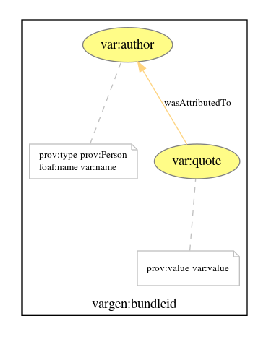

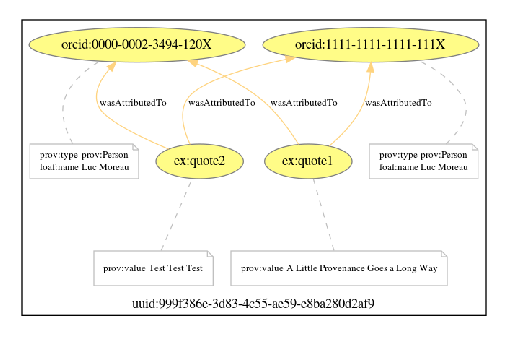

In [9]:
%matplotlib  inline
prov_doc.plot()
instance_doc.plot()